# Monitoring VQE convergence

Variational algorithms in Qiskit, like [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html) and [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html), provide the option for a user to give a callback method that can be used to monitor optimization progress as the algorithm runs and converges to the minimum. The callback is invoked for each functional evaluation by the optimizer and provides the current optimizer value, evaluation count, current optimizer parameters etc. Note that, depending on the specific optimizer this may not be each iteration (step) of the optimizer, so for example if the optimizer is calling the cost function to compute a finite difference based gradient this will be visible via the callback.

This notebook demonstrates using Qiskit's VQE algorithm to plot graphs of the convergence path to ground state energy with a selected set of optimizers.

First, we create a qubit operator for VQE. Here we will use the same operator as used in the algorithms introduction, which was originally computed by Qiskit Nature for an H2 molecule.

In [1]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

We then instantiate our `Estimator` of choice for the evaluation of expectation values within `VQE`. In this case, we will use the `qiskit.primitives.Estimator` shipped with the default Qiskit Terra installation.

In [2]:
from qiskit.primitives import Estimator

estimator = Estimator()

We will now see the VQE callback usage over a set of optimizers for comparison. The minimum energy of the H2 Hamiltonian can be found quite easily so we are able to set maxiters to a small value. We will once again use `TwoLocal` as our selected trial wavefunction (i.e. ansatz).

In [4]:
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals

optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
print("\rOptimization complete      ");

Optimization complete      


Now from the callback data we stored we can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has that characteristic step like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similar values whose difference cannot be seen on the scale of the graph here).

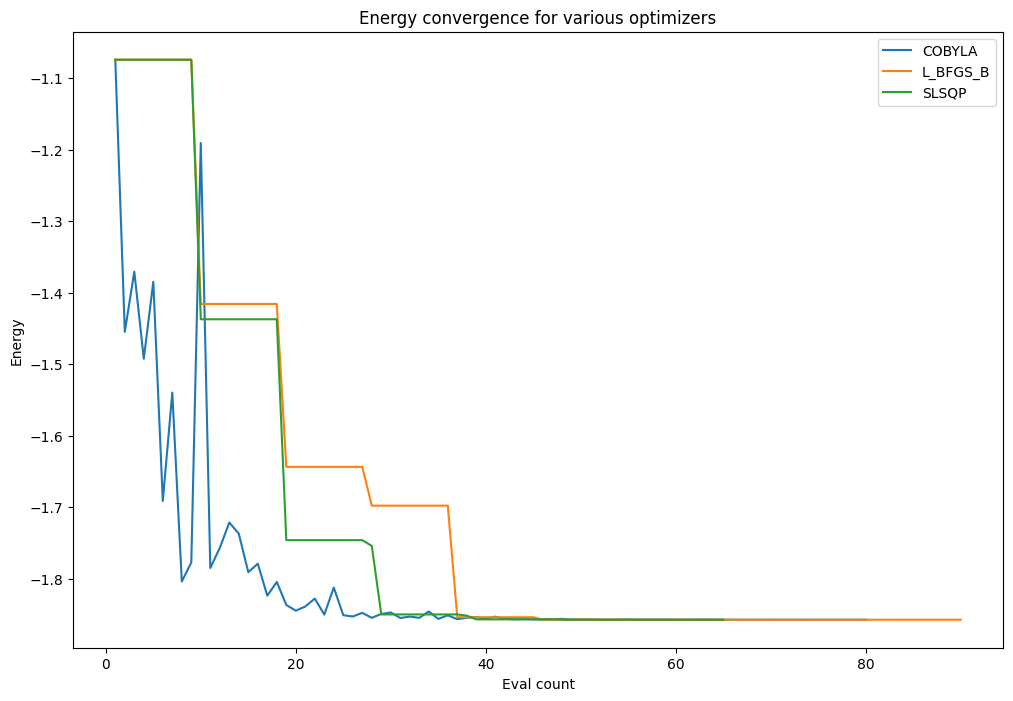

In [5]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

Finally since the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value for the solution. We can now plot the difference from the resultant exact solution as the energy converges with VQE towards the minimum value which should be that exact classical solution.

In [7]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


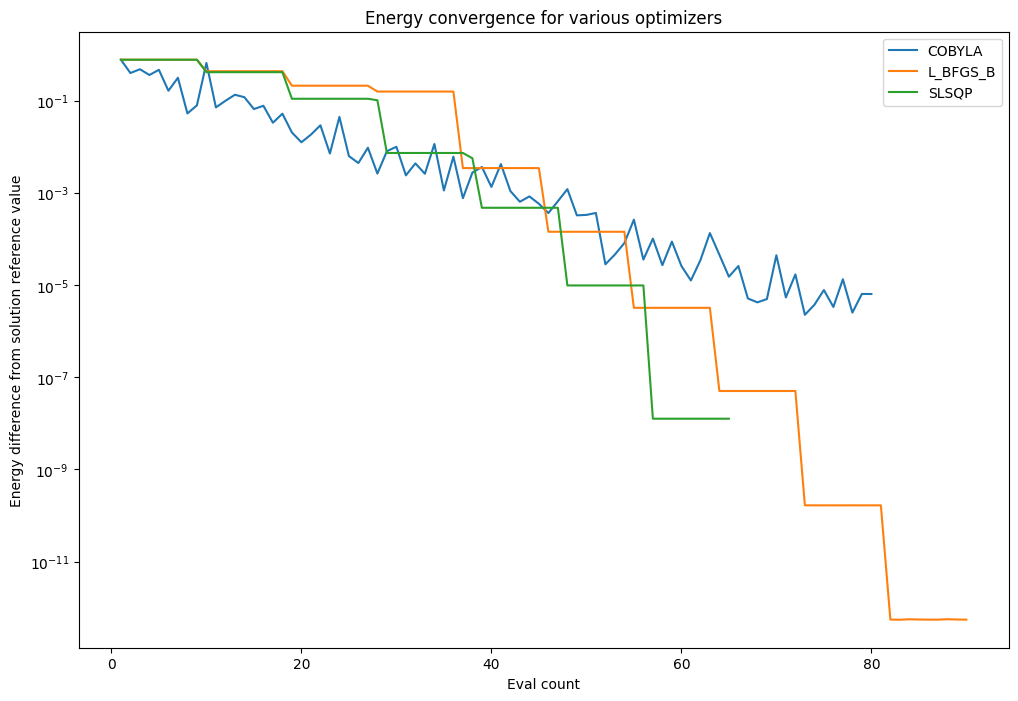

In [8]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_cnts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");

## Using the Primitives Gradient framework

Qiskit's Gradient framework now supports the primitives. This section shows how to use custom gradients within the VQE workflow.

The first step is to initialize both the corresponding primitive and primitive gradient:

In [16]:
from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient as FDGradient

estimator = Estimator()
gradient = FDGradient(estimator, epsilon=0.01)

Now, we can inspect an SLSQP run using the `FiniteDiffEstimatorGradient` from above:

In [20]:
algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

optimizer = SLSQP(maxiter=60)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


vqe = VQE(
    estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient
)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f"Value using Gradient: {result.eigenvalue.real:.5f}")

Value using Gradient: -1.85727


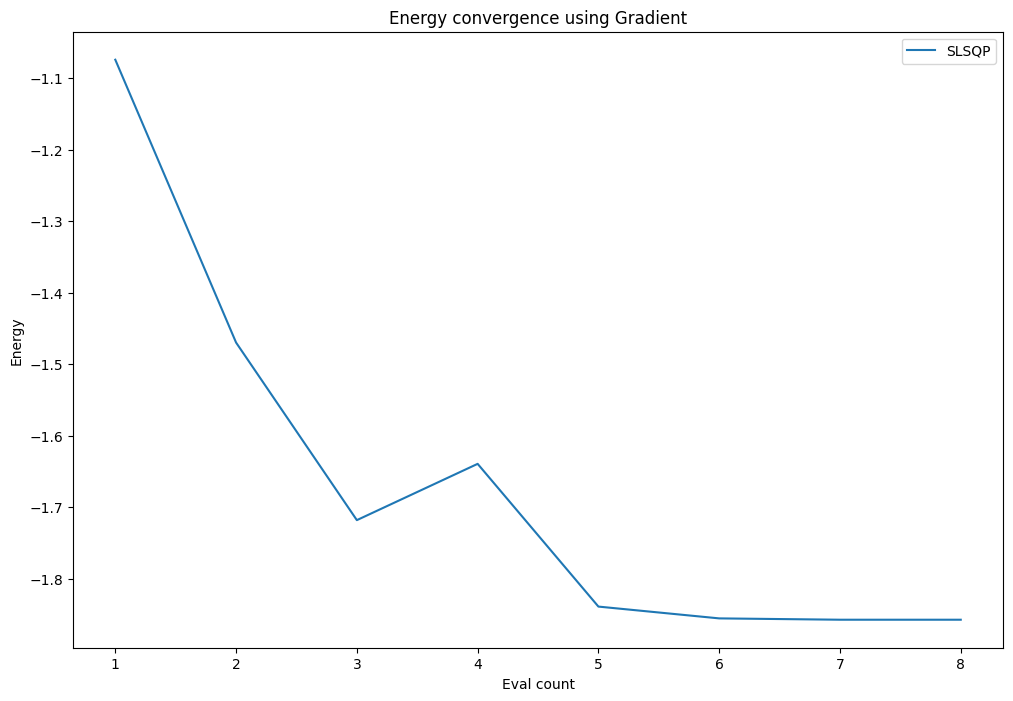

In [21]:
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence using Gradient")
pylab.legend(loc="upper right");

## Monitoring via the logging

Much of the code is instrumented with [Python logging](https://docs.python.org/3/library/logging.html) statements. The logging is configurable to adjust level of logging etc. Here we set the logging level to `INFO`

In [9]:
import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger("qiskit.algorithms.minimum_eigen_solvers.vqe").setLevel(logging.INFO)

and at INFO level logging VQE will include information on the evaluations, as below.

INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.07392554] - 116.41884 (ms), eval count: 1
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.43698938] - 4.05884 (ms), eval count: 2
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.74596698] - 7.40194 (ms), eval count: 3
INFO:qiskit.algorithms.minimum_eigen_solvers.vqe:Energy evaluation returned [-1.75399268] - 6.61016 (ms), eval count: 4

In [10]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright